# Plotting 🗾

### Function Definitions (Long) 📚

Functions for:

- Plotting 2D, with labels and cluster centroids
- Plotting 3D, with labels and cluster centroids
- 3D Interactive plot of the same
- Saving to ITK-SNAP landmarks

In [ ]:
!pip install plotly

     |████████████████████████████████| 19.1 MB 13.1 MB/s eta 0:00:01
You should consider upgrading via the '/scratch4/randalburns/DiffTumor/venv-py38/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colormaps  # Import the correct module for colormaps

organs_dict = {
    'unlabeled/background': 0,
    'aorta': 1,
    'gall_bladder': 2,
    'spleen': 3,
    'stomach': 4,
    'kidney_right': 5,
    'kidney_left': 6,
    'liver': 7,
    'pancreas': 8,
    'postcava': 9
}

reverse_organs_dict = {v: k for k, v in organs_dict.items()}

# Function to plot 2D scatter plot with annotations and cluster centroids with variance ellipses
def plot_2d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 2D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth label numbers.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    
    # Perform PCA to reduce to 2D
    features_2d = features_high_dim
    if features_high_dim.shape[1] > 2:
        pca_2d = PCA(n_components=2)
        features_2d = pca_2d.fit_transform(features_high_dim)
    
    plt.figure(figsize=(12, 8))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap for up to 10 colors

    # Create a color for each label
    label_colors = {label: colors(i) for i, label in enumerate(unique_labels)}
    point_colors = [label_colors[label] for label in labels]
    
    # Create a reverse mapping for hover information
    label_names = [reverse_organs_dict.get(label, f'Label {label}') for label in labels]
    
    # Plot data points
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=point_colors, s=50, alpha=0.7)

    # Add hover information (using mplcursors for interactivity)
    try:
        import mplcursors
        cursor = mplcursors.cursor(scatter, hover=True)
        cursor.connect("add", lambda sel: sel.annotation.set_text(label_names[sel.index]))
    except ImportError:
        print("mplcursors is not installed. Hover functionality is disabled.")

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Compute and plot centroids and variance ellipses
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')

    used_colors = {}
    centroid_labels = []

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_2d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        covariance = np.cov(cluster_points, rowvar=False)
        
        if covariance.shape == (2, 2):
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
            
            # Sort eigenvalues and eigenvectors
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            
            # Compute angle for the ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            
            # Width and height are "full" widths, so multiply by 2
            width, height = 2 * np.sqrt(eigenvalues)
            
            # Create and add the ellipse patch
            ellipse = Ellipse(xy=centroid, width=width, height=height, angle=angle,
                              edgecolor=cmap(i), facecolor='none', linewidth=2)
            plt.gca().add_patch(ellipse)
        
        # Plot centroid as 'X'
        plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=[cmap(i)], label='Centroid')
        used_colors['Centroid'] = cmap(i)
        centroid_labels.append('Centroid')

    # Create legend for ground truth labels
    label_handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=reverse_organs_dict.get(label, f'Label {label}'),
                   markerfacecolor=color, markersize=10) 
        for label, color in label_colors.items()
    ]

    # Create legend for centroids
    centroid_handles = [
        plt.Line2D([0], [0], marker='X', color='w', label='Centroid',
                   markerfacecolor=used_colors['Centroid'], markersize=10)
    ]

    # Combine both legends
    plt.legend(handles=label_handles + centroid_handles, loc='lower left')
    plt.grid(True)
    plt.show()        
# Function to plot 3D scatter plot with annotations and cluster centroids
def plot_3d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 3D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth label numbers.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for ground truth labels using organs_dict
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap
    
    # Create a color for each label
    label_colors = {label: colors(i) for i, label in enumerate(unique_labels)}
    point_colors = [label_colors[label] for label in labels]
    
    # Create label names for hover and legend
    label_names = [reverse_organs_dict.get(label, f'Label {label}') for label in labels]
    
    # Plot data points
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=point_colors, s=50, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # Compute and plot centroids
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')
    
    centroids = []
    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='X', s=200, c=[cmap(i)], label='Centroid')

    # Create legend for ground truth labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=reverse_organs_dict.get(label, f'Label {label}'),
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids (single entry)
    centroid_handle = plt.Line2D([0], [0], marker='X', color='w', label='Centroid',
                                 markerfacecolor='black', markersize=10)
    
    # Combine legends
    ax.legend(handles=handles + [centroid_handle], loc='best')
    plt.show()

import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from typing import Optional, Tuple

def plot_interactive_3d_scatter(
    coordinates: np.ndarray,
    cluster_labels: np.ndarray,
    ground_truth_labels: Optional[np.ndarray] = None,
    axis_min: Optional[Tuple[int, int, int]] = (-25, -25, -25),
    axis_max: Optional[Tuple[int, int, int]] = (50, 50, 50),
    title: str = "Interactive 3D Scatter Plot",
    show_legend: bool = True
):
    """
    Plots an interactive 3D scatter plot with detailed legends for each ground truth organ and cluster centroids.

    Parameters:
    - coordinates (np.ndarray): Array of shape (n, 3) representing 3D coordinates.
    - cluster_labels (np.ndarray): Array of shape (n,) containing cluster assignments for each point.
    - ground_truth_labels (Optional[np.ndarray]): Array of shape (n,) containing ground truth labels for each point.
    - axis_range (Optional[Tuple[int, int, int]]): Tuple specifying the max range for x, y, z axes. Defaults to (512, 512, 512).
    - title (str): Title of the plot.
    - show_legend (bool): Whether to display the legend.

    Returns:
    - A Plotly Figure object displaying the interactive 3D scatter plot.
    """

    # Validate input dimensions
    if coordinates.ndim != 2 or coordinates.shape[1] != 3:
        raise ValueError("Coordinates array must be of shape (n, 3).")

    n_points = coordinates.shape[0]

    if cluster_labels.ndim != 1 or cluster_labels.shape[0] != n_points:
        raise ValueError("cluster_labels must be a 1D array with the same length as coordinates.")

    if ground_truth_labels is not None:
        if ground_truth_labels.ndim != 1 or ground_truth_labels.shape[0] != n_points:
            raise ValueError("ground_truth_labels must be a 1D array with the same length as coordinates.")

    # Extract X, Y, Z coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    z = coordinates[:, 2]

    # Handle ground truth labels
    if ground_truth_labels is not None:
        unique_gt = np.unique(ground_truth_labels)
        num_gt = len(unique_gt)
        gt_color_palette = px.colors.qualitative.Light24
        if num_gt > len(gt_color_palette):
            extended_gt_palette = gt_color_palette * (num_gt // len(gt_color_palette) + 1)
        else:
            extended_gt_palette = gt_color_palette
        gt_colors = {gt: extended_gt_palette[i] for i, gt in enumerate(unique_gt)}
    else:
        gt_colors = {}

    # Create ground truth traces
    data = []
    if ground_truth_labels is not None:
        for gt in unique_gt:
            organ_name = reverse_organs_dict.get(int(gt), f'Label {gt}')
            indices = np.where(ground_truth_labels == gt)[0]
            trace = go.Scatter3d(
                x=x[indices],
                y=y[indices],
                z=z[indices],
                mode='markers',
                marker=dict(
                    size=5,
                    color=gt_colors[gt],
                    opacity=0.8
                ),
                name=organ_name,
                hovertemplate=
                    "<b>Organ:</b> %{text}<br>" +
                    "<b>X:</b> %{x:.2f}<br>" +
                    "<b>Y:</b> %{y:.2f}<br>" +
                    "<b>Z:</b> %{z:.2f}<br>" +
                    "<extra></extra>",
                text=[organ_name] * len(indices)
            )
            data.append(trace)
    else:
        # If no ground truth labels, plot all points with a single color
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color='blue',
                opacity=0.8
            ),
            name='Data Points',
            hovertemplate=
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
        )
        data.append(trace)

    # Calculate and plot centroids as 'X'
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    color_palette = px.colors.qualitative.Plotly
    if num_clusters > len(color_palette):
        extended_palette = color_palette * (num_clusters // len(color_palette) + 1)
    else:
        extended_palette = color_palette
    cluster_colors = {cluster: extended_palette[i] for i, cluster in enumerate(unique_clusters)}

    centroids = []
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        if len(indices) == 0:
            continue
        centroid = coordinates[indices].mean(axis=0)
        centroids.append({
            'cluster': cluster,
            'x': centroid[0],
            'y': centroid[1],
            'z': centroid[2],
            'color': cluster_colors[cluster]
        })

    if centroids:
        centroid_trace = go.Scatter3d(
            x=[c['x'] for c in centroids],
            y=[c['y'] for c in centroids],
            z=[c['z'] for c in centroids],
            mode='markers',
            marker=dict(
                size=8,
                color=[c['color'] for c in centroids],
                symbol='x',
                line=dict(width=2),
                opacity=1.0
            ),
            name='Centroids',
            hovertemplate=
                "<b>Centroid of Cluster:</b> %{text}<br>" +
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
            text=[f'Cluster {c["cluster"]}' for c in centroids]
        )
        data.append(centroid_trace)

    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(title='X'),#, range=[axis_min[0], axis_max[0]]),
            yaxis=dict(title='Y'),#, range=[axis_min[1], axis_max[1]]),
            zaxis=dict(title='Z')#, range=[axis_min[2], axis_max[2]]),
        ),
        legend=dict(
            itemsizing='constant',
            title="Organ Labels",
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        showlegend=show_legend
    )

    # # Define layout with customizable axis ranges
    # layout = go.Layout(
    #     title=title,
    #     scene=dict(
    #         xaxis=dict(title='X', range=[axis_min[0], axis_max[0]]),
    #         yaxis=dict(title='Y', range=[axis_min[1], axis_max[1]]),
    #         zaxis=dict(title='Z', range=[axis_min[2], axis_max[2]]),
    #     ),
    #     legend=dict(
    #         itemsizing='constant',
    #         title="Organ Labels",
    #     ),
    #     margin=dict(l=0, r=0, b=0, t=50),
    #     showlegend=show_legend
    # )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [ ]:
base_cluster_results_dir = "data/generated-data/clustering-results"

## Unlabeled

A.k.a. the plotting function that performs best on Unlabeled metrics: Davies Bouldin Score, Calinski Harabasz Score

That is MiniBatchKmeans for DB and CH scores, but OPTICS for Silhouette Score. OPTICS can only be run on small datasets

<font color='red'>Truth is, from the hyperparameter_search.ipynb, there is no clear winner. All models perform terrible on the metrics. So use MiniBatchKMeans</font>

In [ ]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS, DBSCAN


minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

optics = OPTICS()
dbscan = DBSCAN()

In [ ]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

In [ ]:
middle_unscaled, _ = extract_middle_vectors(flattened_encoded_cts)

## On Raw, Unscaled Data

In [ ]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(middle_unscaled)

In [ ]:
tsne_3d = TSNE(n_components=3, random_state=42).fit_transform(middle_unscaled)

In [ ]:
minibatchkmeans_10.fit(middle_unscaled)

MiniBatchKMeans(n_clusters=10, random_state=42)

In [ ]:
minibatchkmeans_10.labels_

array([7, 8, 3, ..., 7, 7, 3], dtype=int32)

### On a Single CT (Cleaner)

mplcursors is not installed. Hover functionality is disabled.


/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/1200743870.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



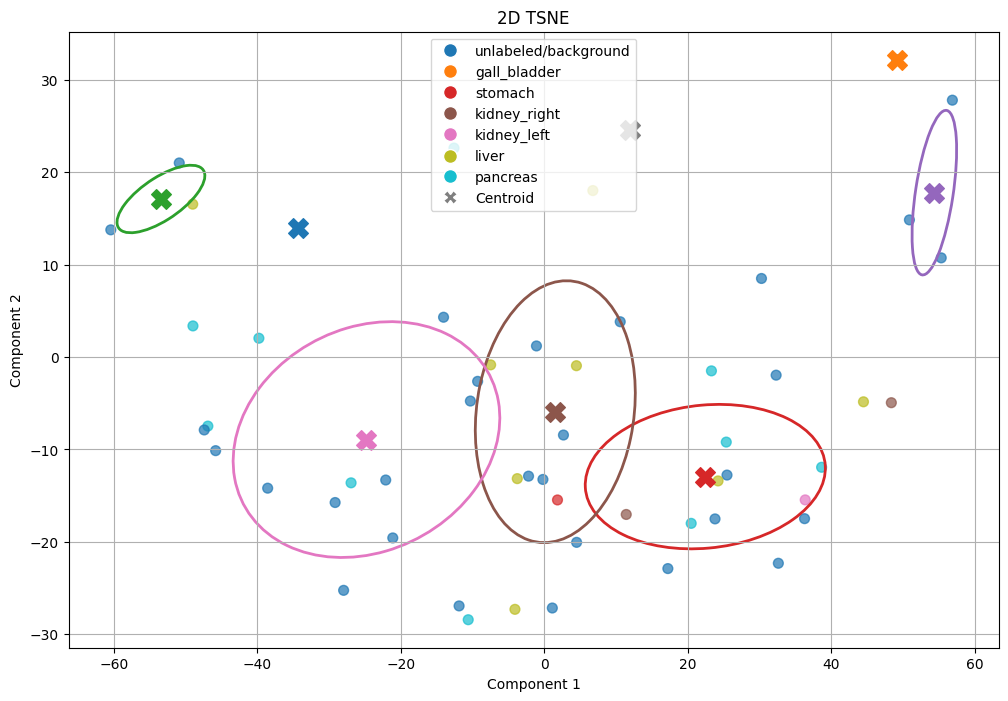

In [ ]:
plot_2d(tsne_2d[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55], all_filtered_ids[:55], minibatchkmeans_10.labels_[:55], "2D TSNE")

### On all 45 CTs

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/899656148.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



mplcursors is not installed. Hover functionality is disabled.


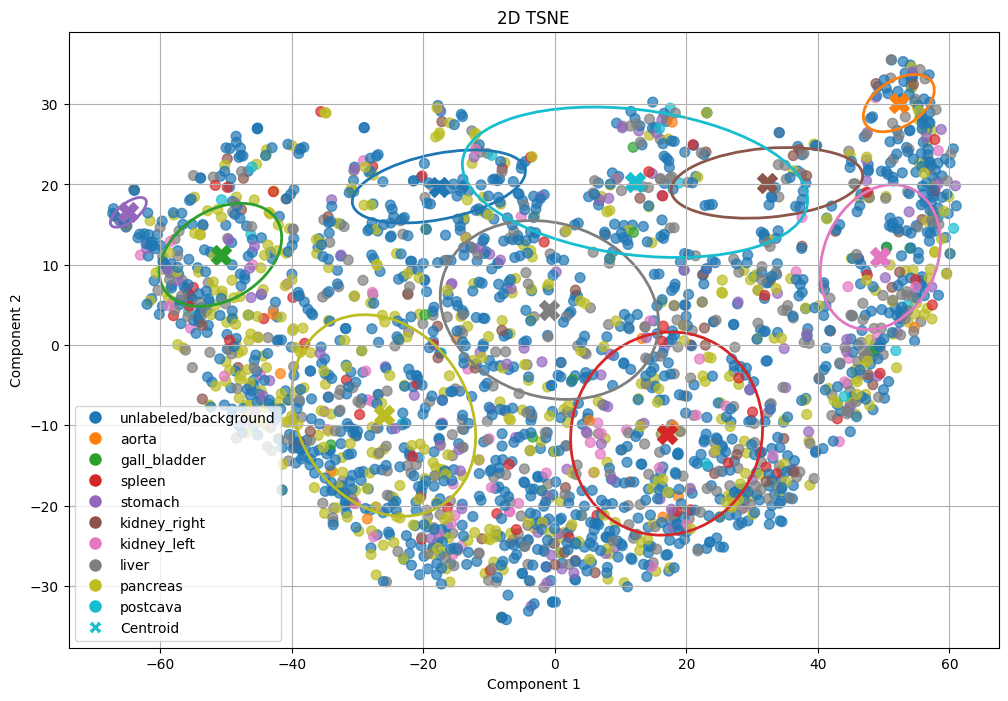

In [ ]:
plot_2d(tsne_2d, sampled_points_multi_organ_labels.numpy().flatten(), all_filtered_ids, minibatchkmeans_10.labels_, "2D TSNE")

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_5259/1200743870.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap


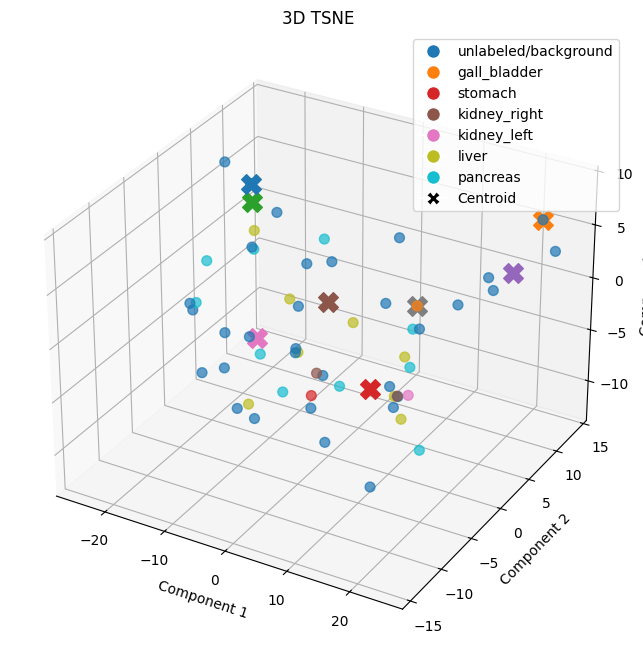

In [ ]:
plot_3d(tsne_3d[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55], all_filtered_ids[:55], minibatchkmeans_10.labels_[:55], "3D TSNE")

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/1200743870.py:144: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



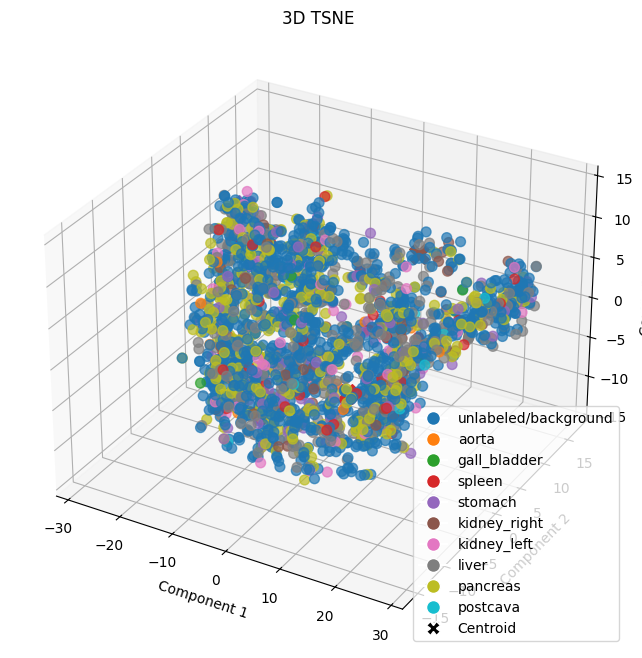

In [ ]:
plot_3d(tsne_3d, sampled_points_multi_organ_labels.numpy().flatten(), all_filtered_ids, minibatchkmeans_10.labels_, "3D TSNE")

In [ ]:
pd.DataFrame(tsne_3d[:55]).describe()

,0,1,2
count,55.000000,55.000000,55.000000
mean,0.982329,-0.719148,-1.420108
std,12.985308,6.147784,5.081944
min,-24.688032,-14.226270,-12.386585
25%,-7.553623,-4.977463,-5.208958
50%,1.964806,-0.256702,-1.317239
75%,11.248823,2.363584,1.889115
max,24.667101,13.544825,8.897179


In [ ]:
plot_interactive_3d_scatter(tsne_3d[:55], minibatchkmeans_10.labels_[:55], sampled_points_multi_organ_labels.numpy().flatten()[:55])#, axis_range=(np.max(tsne_3d),np.max(tsne_3d),np.max(tsne_3d)))

In [ ]:
plot_interactive_3d_scatter(tsne_3d, minibatchkmeans_10.labels_, sampled_points_multi_organ_labels.numpy().flatten(), axis_max=(np.max(tsne_3d),np.max(tsne_3d),np.max(tsne_3d)))

## On PCA, keeping all 8 components

In [ ]:
from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

### Only Using middle vectors

I.e. vectors with coordinates $(12,12,12)$ within the encoded $24^3$

In [ ]:
middle_vecs, indices = extract_middle_vectors(pca_8_features, n_samples=all_encoded_cubes.shape[0])

middle_vecs.shape

(2530, 8)

In [ ]:
features = middle_vecs

In [ ]:
minibatchkmeans_10.fit(features)
minibatchkmeans_6.fit(features)
minibatchkmeans_2.fit(features)
minibatchkmeans_4.fit(features)
minibatchkmeans_8.fit(features)
minibatchkmeans_12.fit(features)
minibatchkmeans_14.fit(features)

optics.fit(features)
dbscan.fit(features)

DBSCAN()

In [ ]:
pd.DataFrame(optics.labels_[:55]).value_counts()

0  
-1     53
 8      1
 10     1
Name: count, dtype: int64

In [ ]:
pd.DataFrame(dbscan.labels_[:55]).value_counts()

0 
 0    32
-1    23
Name: count, dtype: int64

In [ ]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_clusters_mini10 = minibatchkmeans_10.labels_[:55]

In [ ]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


### On Full $24^3$

In [ ]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans

minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

In [ ]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

minibatchkmeans_10.fit(pca_8_features)
minibatchkmeans_6.fit(pca_8_features)
minibatchkmeans_2.fit(pca_8_features)
minibatchkmeans_4.fit(pca_8_features)
minibatchkmeans_8.fit(pca_8_features)
minibatchkmeans_12.fit(pca_8_features)
minibatchkmeans_14.fit(pca_8_features)

MiniBatchKMeans(n_clusters=14, random_state=42)

In [ ]:
pca_8_features.shape

(34974720, 8)

In [ ]:
cluster_labels_mini10 = minibatchkmeans_10.labels_[indices]
cluster_labels_mini6 = minibatchkmeans_6.labels_[indices]
cluster_labels_mini2 = minibatchkmeans_2.labels_[indices]
cluster_labels_mini4 = minibatchkmeans_4.labels_[indices]
cluster_labels_mini8 = minibatchkmeans_8.labels_[indices]
cluster_labels_mini12 = minibatchkmeans_12.labels_[indices]
cluster_labels_mini14 = minibatchkmeans_14.labels_[indices]

cluster_labels_mini10.shape

(2530,)

In [ ]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_sampled_points_coordinates.shape

torch.Size([55, 3])

In [ ]:
first_ct_id = all_filtered_ids[0]

#### Save Clusters as Landmarks for ITK-SNAP

In [ ]:
first_ct_clusters_mini10 = cluster_labels_mini10[:55]

In [ ]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


In [ ]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini6, filename='minibatchKmeans_6clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini2, filename='minibatchKmeans_2clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini4, filename='minibatchKmeans_4clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_6clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_2clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_4clusters.annot'.


In [ ]:
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini8, filename='minibatchKmeans_8clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini12, filename='minibatchKmeans_12clusters.annot', slice_range=5)
save_clusters_as_itk_snap_annotations(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini14, filename='minibatchKmeans_14clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_8clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_12clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_14clusters.annot'.


#### Simply plot Sampled Coordinates and their Clusters in Interactive 3D

In [ ]:
import nibabel as nib
import os

first_ct_raw = nib.load(os.path.join('data/healthy-pancreas', first_ct_id, 'ct.nii.gz')).get_fdata()

In [ ]:
first_ct_raw.shape

(403, 313, 201)

In [ ]:
cluster_labels_mini10

array([5, 1, 8, 8, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 5, 1, 8, 1, 1, 8, 3, 5,
       6, 7, 3, 3, 3, 6, 3, 3, 3, 8, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 5, 3,
       8, 5, 8, 4, 8, 5, 8, 1, 8, 1, 8], dtype=int32)

In [ ]:
plot_interactive_3d_scatter(first_ct_sampled_points_coordinates.numpy(), cluster_labels=cluster_labels_mini10, axis_max=first_ct_raw.shape)

In [ ]:
pd.DataFrame(cluster_labels_mini10).value_counts()

0
1    22
8    11
3    10
5     7
6     2
2     1
4     1
7     1
Name: count, dtype: int64

##### 3D CT plot looks horrific. Never do it again

## Labels: Pancreatic vs. Non-Pancreatic sampled point

The $96^3$ cube is labeled as "pancreatic" vs. not based on the location of its center point. If it's within the pancreas segmentation mask, it's labeled as "pancreatic".

### First 2 and 3 Components

### Only Middle Vectors

I.e. out of the $24^3$, plotting only point with coordinates $(12, 12, 12)$

In [ ]:
import numpy as np
from sklearn.cluster import OPTICS


# Initialize OPTICS
optics = OPTICS()#min_samples=50, xi=0.05, min_cluster_size=0.1)

# Fit the model
optics.fit(middle_vectors_full_pca)

# Retrieve cluster labels
cluster_labels = optics.labels_

# Add cluster labels to a DataFrame for easier handling
middle_vectors_df['OPTICS_Clusters'] = cluster_labels

# Display cluster assignments
print(middle_vectors_df.head())

In [ ]:
np.all(cluster_labels == -1)

In [ ]:
pd.DataFrame(cluster_labels_mini10).value_counts()

In [ ]:
pd.DataFrame(cluster_labels).value_counts()

In [ ]:
plot_3d(middle_vectors_df)

### Datashader Plotting 10 clusters on the PCA-ed features

In [ ]:
import holoviews as hv
from holoviews.operation.datashader import datashade
import datashader as ds
from bokeh.palettes import Category10, Category20, viridis
hv.extension('bokeh')

# Define color palette based on the number of unique clusters
unique_clusters = sorted(df_pca['Cluster'].unique())
num_clusters = len(unique_clusters)

if num_clusters <= 10:
    palette = Category10[10]
elif num_clusters <= 20:
    palette = Category20[20]
else:
    palette = viridis(num_clusters)

# Create a categorical color map
color_key = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

# Create HoloViews Points element with 'Cluster' as a categorical dimension
points = hv.Points(df_pca, ['PC1', 'PC2'], 'Cluster')

# Apply Datashader with the defined color map and appropriate aggregator
shaded = datashade(
    points, 
    cmap=palette, 
    aggregator=ds.count_cat('Cluster'),  # Aggregate counts per cluster
).opts(
    width=800,
    height=600,
    title='KMeans Clusters on First Two Principal Components'
)

# Display the plot
shaded

##### <font color='orange'> 3D non-datashader: This is gonna take forever</font>

Datashader doesn't support 3D plots. This means very slow projection

## Labels: Healthy vs. Unhealthy CT

In [ ]:
patient_ids = healthy_patient_ids + panc_patient_ids
pancreas_vs_background_labels = pancreas_vs_background_labels.tolist()

### Plotting all (38M, 8) vectors

Using 2D PCA features

In [ ]:
# Results for PCA on (50, 55, 8, 24, 24, 24), 8

from matplotlib import pyplot as plt

plt.scatter(pca_results[:, 0], pca_results[:, 1], c=pancreas_vs_background_labels, cmap='viridis', s=1)

#### Same Plot but Much Faster - holoview, bokeh

In [ ]:
pca_solver_2d = PCA(n_components=2, random_state=42)

pca_results = pca_solver_2d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
hv.extension('bokeh')  # Initialize HoloViews with the Bokeh backend
import datashader as ds
from holoviews.operation.datashader import datashade
from sklearn.decomposition import PCA
import pandas as pd
from bokeh.palettes import Category10, Category20


# Create a DataFrame
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

df['Label'] = pancreas_vs_background_labels.numpy().astype(str)  # Convert labels to string for categorical coloring

# Define color palette
unique_labels = df['Label'].unique()
num_labels = len(unique_labels)
palette = Category10[10] if num_labels <= 10 else Category20[20]

# Create a color key mapping each label to a color
color_key = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

# Create HoloViews Points with 'Label' as a categorical dimension
points = hv.Points(df, ['PC1', 'PC2'], ['Label'])

# Apply Datashader with the color_key
shaded = datashade(points, cmap=color_key, how='log', aggregator=ds.count_cat('Label')).opts(
    width=800,  # Set the width
    height=600  # Set the height
)

# Display the shaded plot
shaded

In [ ]:
from sklearn.decomposition import PCA

pca_solver_3d = PCA(n_components=3, random_state=42)

pca_results_3d = pca_solver_3d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
import pandas as pd
import numpy as np
import plotly.io as pio

# Initialize HoloViews with the Plotly backend
hv.extension('plotly')

# Assuming you have 3 PCA components and labels
# Generate some random PCA data for illustration
pca_results = np.random.rand(1000, 3)  # Replace with your actual PCA results
pancreas_vs_background_labels = np.random.randint(0, 5, size=1000)  # Replace with your actual labels

# Create a DataFrame with PCA results and labels
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'])
df['Label'] = pancreas_vs_background_labels.astype(str)  # Convert labels to string for categorical coloring

# Create a 3D scatter plot using HoloViews and Plotly
scatter = hv.Scatter3D(df, kdims=['PC1', 'PC2', 'PC3'], vdims='Label').opts(
    color='Label',  # Color based on Label
    cmap='Category10',  # Choose a colormap for the labels
    size=5,  # Set marker size
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
    marker='circle',  # Set marker type
    title="3D PCA Scatter Plot"  # Add a title
)

# Display the 3D plot
scatter

### Hyperparameter Search Plots

#### Best PCA

First, perform best clustering - need to find optimal hyperparameters above

<font color='cyan'>From Excel spreadsheet, best choice was: PCA - 36 components - 6 clusters AND T-SNE: 7 clusters, learning_rate	n_components	n_iter	perplexity 10	42	1000	50</font>

In [ ]:
from sklearn.decomposition import PCA

best_PCA = PCA(n_components=36, random_state=42)

best_pca_features = best_PCA.fit_transform(flattened_features_std)

In [ ]:
from sklearn.cluster import KMeans

best_pca_clustering = KMeans(n_clusters=7, random_state=42)

In [ ]:
best_pca_clusters = best_pca_clustering.fit_predict(best_pca_features)

In [ ]:
best_pca_features.shape

In [ ]:
# --- Plotting the Results ---

# Plot the best unsupervised result in 2D
plot_2d(best_pca_features, pancreas_vs_background_labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_pca_features, pancreas_vs_background_labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_pca_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_pca_clusters,
    title='Best Unsupervised Result - PCA - 3D (Interactive)'
)

#### Best T-SNE

In [ ]:
from sklearn.manifold import TSNE

best_tsne = TSNE(n_components=42, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')

best_tsne_features = best_tsne.fit_transform(flattened_features_std)

In [ ]:
best_tsne_clustering = KMeans(n_clusters=7, random_state=42)

best_tsne_clusters = best_tsne_clustering.fit_predict(best_tsne_features)

In [ ]:
plot_2d(best_tsne_features, pancreas_vs_background_labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_tsne_features, pancreas_vs_background_labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_tsne_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)',
    plot_axes=True
)

Outlier 5070

![5070.png](mkdown-imgs/5070.png)


Outlier 3427

![3427.png](mkdown-imgs/3427.png)


Outlier 928 - I think this CT is just Shifted from the rest, so it appears as an outlier



![928.png](mkdown-imgs/928.png)

#### T-SNE w/ only 2,3 components (Worse)

In [ ]:
best_2d_tsne = TSNE(n_components=2, perplexity=40, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_2d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

best_3d_tsne = TSNE(n_components=3, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_3d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

In [ ]:
best_2d_tsne_features = best_2d_tsne.fit_transform(flattened_features_std)
best_3d_tsne_features = best_3d_tsne.fit_transform(flattened_features_std)

best_2d_tsne_clusters = best_2d_tsne_clusterer.fit_predict(best_2d_tsne_features)
best_3d_tsne_clusters = best_3d_tsne_clusterer.fit_predict(best_3d_tsne_features)

In [ ]:
plot_2d(best_2d_tsne_features, pancreas_vs_background_labels, patient_ids, best_2d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

In [ ]:
best_3d_tsne_features.shape

In [ ]:
plot_3d(best_3d_tsne_features, pancreas_vs_background_labels, patient_ids, best_3d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_3d_tsne_features,
    labels=pancreas_vs_background_labels,
    patient_ids=patient_ids,
    clusters=best_3d_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)')

    

# Supervised Clustering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
def apply_nca(features, labels, n_components):
    """
    Apply Neighborhood Components Analysis (NCA).

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=42)
    nca.fit(features, labels)
    return nca.transform(features)


def apply_pls(features, labels, n_components):
    """
    Apply Partial Least Squares (PLS) regression.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of components to keep.

    Returns:
        numpy.ndarray: Transformed features.
    """
    lb = LabelBinarizer()
    labels_binarized = lb.fit_transform(labels)
    pls = PLSRegression(n_components=n_components)
    pls.fit(features, labels_binarized)
    return pls.transform(features)


def apply_supervised_umap(features, labels, n_components, n_neighbors=15, min_dist=0.1):
    """
    Apply Supervised UMAP.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    )
    return reducer.fit_transform(features, y=labels)

In [ ]:
def evaluate_supervised_methods(features, labels):
    """
    Evaluate clustering with supervised dimensionality reduction methods.

    Parameters:
        features (numpy.ndarray): Scaled features.
        labels (numpy.ndarray): Class labels.

    Returns:
        dict: Results for each method.
    """
    n_components_list = list(range(2, min(features.shape[1], 56), 5))
    n_clusters_list = list(range(2, 8))
    dim_reduction_methods = ['NCA', 'PLS', 'Supervised UMAP']
    clustering_methods = ['kmeans', 'agglomerative', 'gmm']
    
    results = {}
    
    for method in dim_reduction_methods:
        print(f"\nDimensionality Reduction Method: {method}")
        results[method] = {}
        for n_components in n_components_list:
            print(f"  n_components = {n_components}")
            if method == 'NCA':
                try:
                    transformed_features = apply_nca(features, labels, n_components)
                except Exception as e:
                    print(f"    NCA failed at n_components={n_components}: {e}")
                    continue
            elif method == 'PLS':
                try:
                    transformed_features = apply_pls(features, labels, n_components)
                except Exception as e:
                    print(f"    PLS failed at n_components={n_components}: {e}")
                    continue
            elif method == 'Supervised UMAP':
                transformed_features = apply_supervised_umap(features, labels, n_components)
            
            results_key = f"n_components_{n_components}"
            results[method][results_key] = pd.DataFrame(
                index=n_clusters_list,
                columns=clustering_methods
            )
            
            for n_clusters in n_clusters_list:
                for cluster_method in clustering_methods:
                    evaluation = cluster_and_evaluate(
                        transformed_features,
                        method=cluster_method,
                        n_clusters=n_clusters
                    )
                    # Store Silhouette Score
                    results[method][results_key].loc[n_clusters, cluster_method] = evaluation['Silhouette Score']
        print("  Evaluation complete.")
    return results

In [ ]:
supervised_results = evaluate_supervised_methods(flattened_features_std, pancreas_vs_background_labels)

In [ ]:
for method, n_components_dict in supervised_results.items():
    print(f"\nResults for {method}:\n")
    for n_components, df in n_components_dict.items():
        print(f"{n_components}")
        print(df)
        print("\n")

Based on the Silhouette Scores, the best clustering result is:

	•	Dimensionality Reduction Method: Supervised UMAP
	•	Number of Components (n_components): 17
	•	Clustering Method: K-Means
	•	Number of Clusters (n_clusters): 2
	•	Silhouette Score: 0.959937


Saving that as a TSV for Projector.tensorflow.org